<table>
<tr>    
<td style="text-align: center">
<h1>Convolutional Neural Networks<br>and dealing with small training datasets using data augmentation</h1>
<h2><a href="http://home.agh.edu.pl/~horzyk/index.php">Adrian Horzyk</a></h2>
</td> 
<td>
<img src="http://home.agh.edu.pl/~horzyk/im/AdrianHorzyk49BT140h.png" alt="Adrian Horzyk, Professor" title="Adrian Horzyk, Professor" />        
</td> 
</tr>
</table>
<h3><i>Welcome to the interactive lecture and exercises where you can check everything by yourself and experiment!</i></h3>

## Deep learning for small training data problems

Maybe you heard that deep learning only works when lots of data are available. This is, in part, a valid point because one fundamental characteristic of deep learning is that many training data are able to find interesting and enough frequent features in these data without manual feature engineering. This can only be achieved when lots of training examples are available. This is especially true for problems where the input samples are very high-dimensional, like images, where the input space dimension is defined by the image resolution.

However, what constitutes "lots" of samples is relative to the size and depth of the network you are trying to train. It isn't possible to train a convnet to solve a complex problem with just a few tens of examples, but a few hundred can sometimes suffice if the model is small and well-regularized and if the task is simple. 

Because convnets learn local, translation-invariant features, they are very data-efficient on perceptual problems. Training a convnet from scratch on a very small image dataset will still yield reasonable results despite a relative lack of data, without the need for any custom feature engineering. You will try to do it here in this notebook!

What's more, deep learning models are, by nature, highly repurposable. It means that you can take an image classification or speech-to-text model trained on a large-scale dataset and then reuse it on a significantly different problem with only minor changes. This we call <b>transfer learning</b>. Specifically, in the case of computer vision, many pre-trained models (usually trained on the ImageNet dataset) are publicly available for download and can be used to bootstrap powerful vision models out of very little data.

Having to train an image classification model using only very little data is a common situation that you likely encounter yourself in practice in a professional context.

Having "few" samples can mean anywhere from a few hundred to few tens of thousands of images. The definition of "few" depends on how many data dimensions we have. We demonstrate it by classifying images of dogs and cats, using a dataset containing 4000 pictures of cats and dogs (2000 cats, 2000 dogs), which input data space dimension is `img_rows` x `img_cols` = 150 x 150 = 22,500. Our workflow will be as follows:

* First, we will divide this dataset into 2000 training images, 1000 validation images, and 1000 testing images.

* Next, we will train a new model from scratch, starting with a small convnet on our 2000 training samples, without any regularization, to set a baseline for what can be achieved.

* Then, we will introduce <b>data augmentation</b>, a powerful technique for mitigating overfitting in computer vision. By leveraging data augmentation, we will improve our network to reach a higher accuracy of the model.

* Finally, we will apply <b>feature extraction with a pre-trained network</b>, and <b>fine-tuning a pre-trained network</b> to increase the final model peformance.

These strategies together will constitute your basic future toolbox for tackling the problem of doing computer vision with small datasets. Next, we use <b>transfer learning</b> to train the model faster and better, using pre-trained models on a big dataset to use well-trained features to adapt the model for similar tasks easier and faster!

For now, let's get started by getting our hands on the data and preparing them for our experiments.

<img src="http://home.agh.edu.pl/~horzyk/lectures/jupyternotebooks/images/catsvsdogssamples.png" title="examples of cats and dogs" />

## Downloading the data

The cats vs. dogs dataset that we will use isn't packaged with Keras, so we have to download and preprocess it. It was made available by <a href="https://www.kaggle.com">Kaggle.com</a> as part of a computer vision competition in late 2013. You can download the original dataset at: <a href="https://www.kaggle.com/c/dogs-vs-cats/data">`https://www.kaggle.com/c/dogs-vs-cats/data`</a> (you will need to create a Kaggle account if you don't already have one). The pictures are medium-resolution (150 x 150 pixels) color JPEGs. 

Unsurprisingly, the cats vs. dogs Kaggle competition in 2013 was won by entrants who used convnets. The best entries could achieve up to 95% accuracy. In our example, we will get fairly close to this accuracy, even though we will be training our models on 8% of the data that were available to the competitors.

This original dataset contains 25,000 images of cats and dogs (12,500 from each class) and is 543MB large (when compressed). After downloading and uncompressing it, we will create a new dataset containing three subsets: a training set with 1000 samples of each class, a validation set with 500 samples of each class, and finally, a test set with 500 samples of each class. We have to crop the dataset because of the training time. However, if you have enough powerful GPGPU units, you can try to train, validate, and test your final experimental model on the whole dataset.

Here are a few lines of code to do this:

In [1]:
import numpy as np
import tensorflow as tf
import keras
import os, shutil

print ("TensorFlow version: " + tf.__version__)
print ("Keras version: " + keras.__version__)

from keras import models
from keras import layers

TensorFlow version: 2.10.0
Keras version: 2.10.0


In [2]:
# The path to store trained models
models_dir = 'C:/ml/models/'
if not os.path.exists(models_dir):
    os.mkdir(models_dir)

# The path to the directory where the original dataset was uncompressed
original_dataset_dir = 'C:/ml/data/kaggle/original/train'

# The directory where we will store our smaller dataset
base_dir = 'C:/ml/data/kaggle/processed/cats_and_dogs_small'
if not os.path.exists(base_dir):
    os.mkdir(base_dir)

# Directories for our training, validation and test splits
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
    os.mkdir(validation_dir)
test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
    os.mkdir(test_dir)

# Directory with our training cat pictures
train_cats_dir = os.path.join(train_dir, 'cats')
if not os.path.exists(train_cats_dir):
    os.mkdir(train_cats_dir)

# Directory with our training dog pictures
train_dogs_dir = os.path.join(train_dir, 'dogs')
if not os.path.exists(train_dogs_dir):
    os.mkdir(train_dogs_dir)

# Directory with our validation cat pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
if not os.path.exists(validation_cats_dir):
    os.mkdir(validation_cats_dir)

# Directory with our validation dog pictures
validation_dogs_dir = os.path.join(validation_dir, 'dogs')
if not os.path.exists(validation_dogs_dir):
    os.mkdir(validation_dogs_dir)

# Directory with our validation cat pictures
test_cats_dir = os.path.join(test_dir, 'cats')
if not os.path.exists(test_cats_dir):
    os.mkdir(test_cats_dir)

# Directory with our validation dog pictures
test_dogs_dir = os.path.join(test_dir, 'dogs')
if not os.path.exists(test_dogs_dir):
    os.mkdir(test_dogs_dir)

# Copy first 1000 cat images to train_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_cats_dir, fname)
    shutil.copyfile(src, dst)

# Copy next 500 cat images to validation_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 cat images to test_cats_dir
fnames = ['cat.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_cats_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy first 1000 dog images to train_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(train_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to validation_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(validation_dogs_dir, fname)
    shutil.copyfile(src, dst)
    
# Copy next 500 dog images to test_dogs_dir
fnames = ['dog.{}.jpg'.format(i) for i in range(1500, 2000)]
for fname in fnames:
    src = os.path.join(original_dataset_dir, fname)
    dst = os.path.join(test_dogs_dir, fname)
    shutil.copyfile(src, dst)

Let's count and check how many images we have in each training split (train/validation/test):

In [3]:
print('total training cat images:', len(os.listdir(train_cats_dir)))

total training cat images: 1000


In [4]:
print('total training dog images:', len(os.listdir(train_dogs_dir)))

total training dog images: 1000


In [5]:
print('total validation cat images:', len(os.listdir(validation_cats_dir)))

total validation cat images: 500


In [6]:
print('total validation dog images:', len(os.listdir(validation_dogs_dir)))

total validation dog images: 500


In [7]:
print('total test cat images:', len(os.listdir(test_cats_dir)))

total test cat images: 500


In [8]:
print('total test dog images:', len(os.listdir(test_dogs_dir)))

total test dog images: 500


So, we have indeed 2000 training images, 1000 validation images, and 1000 test images. In each split, there is the same number of samples from each class: this is <b>a balanced binary classification problem</b>, which means that <b>classification accuracy</b> will be an appropriate measure of success.

## Building our first simple network

Our convnet will be a stack of alternated `Conv2D` (with `relu` activation functions in all hidden layers and `softmax`) and `MaxPooling2D` layers.

However, since we are dealing with bigger images than for the MNIST data and a more complex problem, we should make our network accordingly larger, i.e., it will have one more `Conv2D` + `MaxPooling2D` stage. This serves both to augment the capacity of the network, and to further reduce the size of the feature maps so that they are not overly large when we reach the `Flatten` layer (not to produce too many parameters in the first `Dense` layer). Here, since we start from inputs of size 150x150 (a somewhat arbitrary choice), we end up with feature maps of size no more than 7x7 right before the `Flatten` layer.

Note that the depth of the feature maps is progressively increasing in the network (from 32 to 128), while the size of the feature maps is decreasing (from 148x148 to 5x5) as we can see in `model.summary()` below. In this way, we construct most of the convnets.

Since we are attacking a binary classification problem, we are ending the network with a single unit (a `Dense` layer of size 1) and a `sigmoid` activation. This unit will encode the probability that the network is looking at one class or the other, where one class is represented by 0 and the second class by 1.

In [9]:
from keras import layers
from keras import models

img_rows = 150
img_cols = 150

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(64, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Conv2D(128, (3, 3), activation='relu'))
model1.add(layers.MaxPooling2D((2, 2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(256, activation='relu'))
model1.add(layers.Dense(1, activation='sigmoid'))

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [10]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 17, 17, 128)      0

For our compilation step, we'll go with the `RMSprop` optimizer as usual (later we can experiment with different optimizers). Since we ended our network with a single sigmoid unit, we will use binary crossentropy (`binary_crossentropy`) as our loss function:

In [11]:
#from keras import optimizers
import tensorflow
from tensorflow.keras.optimizers import RMSprop

model1.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

## <a href="https://keras.io/api/preprocessing/image/">Data preprocessing</a>

Data fed to the network must be appropriately formatted into floating point tensors. Currently, our data sits on a drive as JPEG files, so we must perform the following steps to get it into our network:

* Read the picture files in the JPEG format.
* Decode the JPEG content to RBG grids of pixels.
* Convert them into floating point tensors.
* Rescale the pixel values (between 0 and 255) to the $[0, 1]$ interval because neural networks prefer to deal with small input values. (Note: I pay attention to the coding method $[0, 1]$, which allows you to pay attention only to the strongest features, and not to the lack of them. Then the features should be coded in the range $[-1, 1]$, which together with negative weights can make it possible.)

Keras has utilities to take care of these steps automatically because it has a module with image processing helper tools, located at `keras.preprocessing.image` (`tensorflow.keras.preprocessing.image`). In particular, it contains the class `ImageDataGenerator`, which allows quickly set up Python generators that can automatically turn image files on disk into batches of pre-processed tensors. We will implement it here.

In [12]:
from keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    # This is the target directory
    train_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    # This is the target directory
    validation_dir,
    # All images will be resized to 150x150
    target_size=(img_rows, img_cols),
    # The size of baches of images
    batch_size=20,
    # Since we use binary_crossentropy loss, we need binary labels
    class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


Let's take a look at the output of one of these generators: it yields batches of 150x150 RGB images (shape `(20, 150, 150, 3)`) and binary labels (shape `(20,)`). 20 is the number of samples in each batch (the `batch_size`). Note that the generator yields these batches indefinitely: it just loops endlessly over the images present in the target folder. For this reason, we need to `break` the iteration loop at some point.

In [13]:
for data_batch, labels_batch in train_generator:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (20, 150, 150, 3)
labels batch shape: (20,)


Let's fit our model to the data using the generator. We do it using the `fit`. It expects as the first argument a Python generator that will yield batches of inputs and targets indefinitely as ours does. Because the data is being generated endlessly, the generator needs to know example how many samples to draw from the generator before declaring an epoch over. This is the role of the `steps_per_epoch` argument: after having drawn `steps_per_epoch` batches from the generator, i.e. after having run for `steps_per_epoch` gradient descent steps, the fitting process will go to the next epoch. In our case, batches are 20-sample large, so it will take 100 batches until we see our target of 2000 samples (20 x 100 = 2000).

When using `fit`, one may pass a `validation_data`. Importantly, this argument is allowed to be a data generator itself, but it could be a tuple of Numpy arrays as well. If you pass a generator as `validation_data`, then this generator is expected to yield batches of validation data endlessly, and thus you should also specify the `validation_steps` argument, which tells the process how many batches to draw from the validation generator for evaluation. For validation data, we see our target of 1000 samples (20 x 50 = 1000).

In [14]:
history1 = model1.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 26s 178ms/step - loss: 0.6924 - acc: 0.5250 - val_loss: 0.6861 - val_acc: 0.5420
Epoch 2/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6807 - acc: 0.5800 - val_loss: 0.6980 - val_acc: 0.5110
Epoch 3/30
100/100 [==============================] - 6s 64ms/step - loss: 0.6643 - acc: 0.6045 - val_loss: 0.7586 - val_acc: 0.5060
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 0.6522 - acc: 0.6265 - val_loss: 0.6844 - val_acc: 0.5700
Epoch 5/30
100/100 [==============================] - 6s 62ms/step - loss: 0.6395 - acc: 0.6290 - val_loss: 0.6459 - val_acc: 0.6210
Epoch 6/30
100/100 [==============================] - 6s 63ms/step - loss: 0.6274 - acc: 0.6665 - val_loss: 0.6435 - val_acc: 0.6290
Epoch 7/30
100/100 [==============================] - 7s 69ms/step - loss: 0.6015 - acc: 0.6860 - val_loss: 0.6242 - val_acc: 0.6550
Epoch 8/30
100/100 [==============================] - 6s 63ms/step 

It is good practice to always save your models after training to use them later for comparisons or <b>transfer learning</b>:

In [15]:
model1.save(models_dir + 'cats_and_dogs_small_1.h5')

Let's plot the loss and accuracy of the model over the training and validation data during training:

In [16]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html
    
def PlotAccuracyComparison(acc, val_acc, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def PlotLossComparison(loss, val_loss, lab = '*'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

<Figure size 432x288 with 0 Axes>

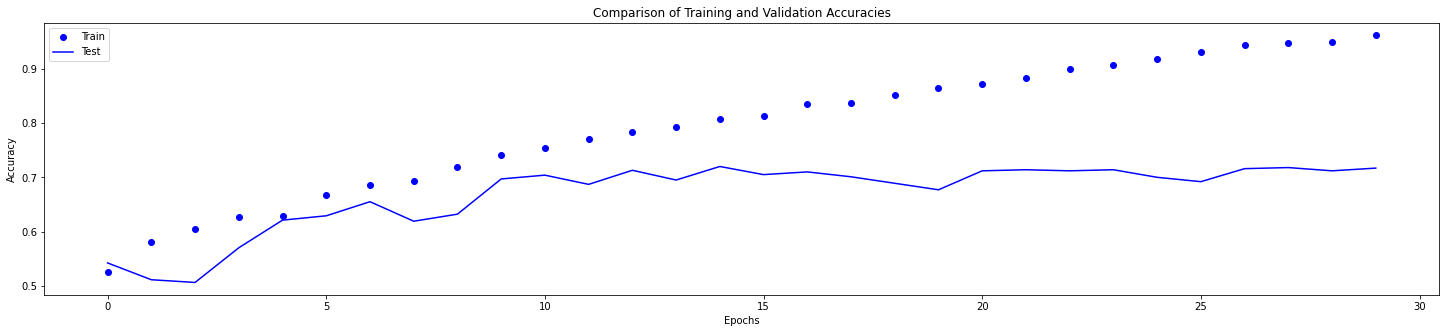

<Figure size 432x288 with 0 Axes>

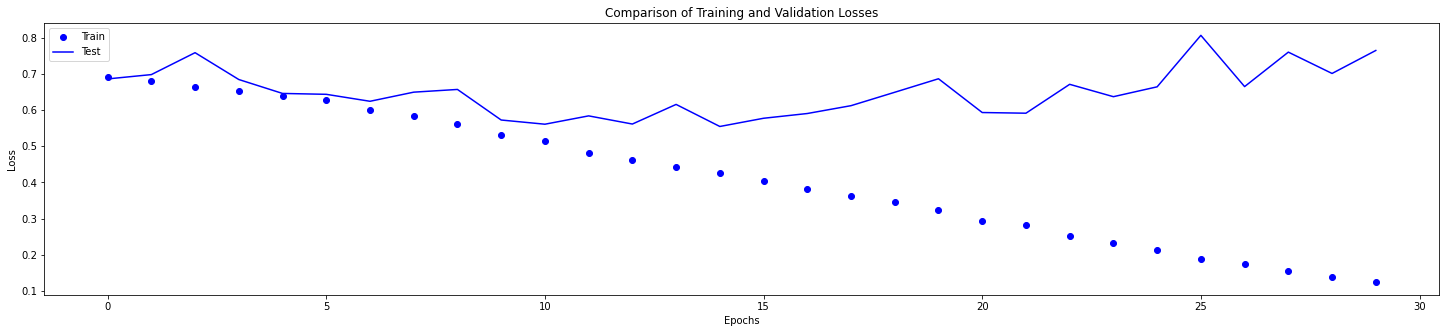

In [17]:
acc1 = history1.history['acc']
val_acc1 = history1.history['val_acc']
loss1 = history1.history['loss']
val_loss1 = history1.history['val_loss']

PlotAccuracyComparison(acc1, val_acc1, lab = 'Model 1')

PlotLossComparison(loss1, val_loss1, lab = 'Model 1')

These plots present dreadful overfitting. The training accuracy increases gradually over time, achieving more than 96% accuracy in the 30th epoch, as well as the training loss decreases gradually over time. On the other hand, the validation accuracy stalls at 70-73%. Our validation loss reaches its minimum after only a few epochs, then fluctuates and rises not beneficially.

Because we only have relatively few training samples (2000), overfitting is going to be our number one concern. You already know about a number of techniques that can help mitigate overfitting, such as dropout and weight decay (L1 or L2 regularization). We are now going to introduce a new one - <b>data augmentation</b> - specific to computer vision and used almost universally when processing images with deep learning models.

## Using data augmentation

Overfitting is caused by having too few samples to learn from and to cover input data space enough representatively, rendering us unable to train a model able to generalize to new data. Data augmentation takes the approach of generating more training data from existing training samples, by "augmenting" the samples via a number of random transformations (like rotation, shifting, zooming, flipping etc.) that yield believable-looking images. The goal is that at training time, the model would never see the exact same picture twice. This helps the model get exposed to more aspects of the data and generalize better. But be careful, the extension operations must be properly matched to the specifics of the training data, otherwise the efficiency of the model may drop.

In Keras, this can be done by configuring a number of random transformations to be performed on the images read by the `ImageDataGenerator` instance. Let's do it with our dataset:

In [18]:
img_rows = 150
img_cols = 150

from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
      rotation_range=50,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

These are just a few of the options available (you can find more in the <a href="https://keras.io/api/preprocessing/image/">Keras documentation</a>):

* `rotation_range` is a value in degrees (0-180), a range within which to randomly rotate pictures.
* `width_shift` and `height_shift` are ranges (as a fraction of total width or height) within which to randomly shift pictures vertically or horizontally.
* `shear_range` is for randomly applying shearing transformations.
* `zoom_range` is for randomly zooming inside pictures.
* `horizontal_flip` is for randomly flipping half of the images horizontally - relevant when there are no assumptions of horizontal asymmetry (e.g., real-world pictures).
* `fill_mode` is the strategy used for filling in newly created pixels, which can appear after a rotation or a width/height shift.

Let's take a look how our augmented images of cats or dogs will look like:

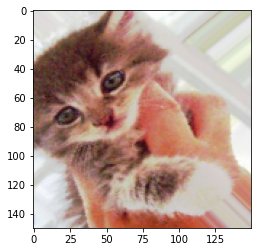

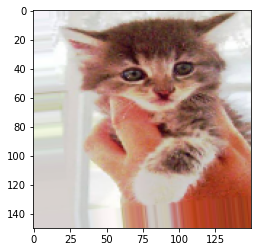

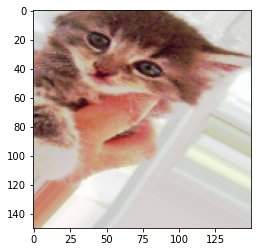

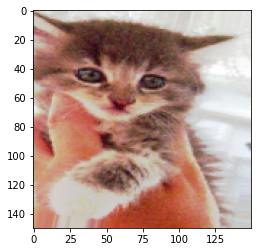

In [19]:
# This is module with image preprocessing utilities
from tensorflow.keras.preprocessing import image

fnames = [os.path.join(train_cats_dir, fname) for fname in os.listdir(train_cats_dir)]

# We pick one image to "augment"
img_path = fnames[3]

# Read the image and resize it
img = image.load_img(img_path, target_size=(img_rows, img_cols))

# Convert it to a Numpy array with shape (150, 150, 3)
x = image.img_to_array(img)

# Reshape it to (1, 150, 150, 3)
x = x.reshape((1,) + x.shape)

# The .flow() command below generates batches of randomly transformed images.
# It will loop indefinitely, so we need to `break` the loop at some point!
i = 0
for batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 4 == 0:
        break

plt.show()

If we train a new network using this data augmentation configuration, our network will never see twice the same input. However, the inputs that it sees are still heavily intercorrelated since they come from a small number of original images -- we cannot produce new information, we can only remix existing information. As such, this might not be quite enough to completely get rid of overfitting. To further fight overfitting, we will also add a Dropout layer to our model right before the densely-connected classifier:

In [20]:
from keras import layers
from keras import models
from keras import optimizers

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(64, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Conv2D(128, (3, 3), activation='relu'))
model2.add(layers.MaxPooling2D((2, 2)))
model2.add(layers.Flatten())
model2.add(layers.Dropout(0.5))
model2.add(layers.Dense(256, activation='relu'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

Let's take a look at how the dimensions of the feature maps change with every successive layer:

In [21]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 17, 17, 128)     

Let's train our network using data augmentation and dropout:

In [22]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20, #32
        class_mode='binary')

#history2 = model2.fit_generator(
history2 = model2.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 14s 132ms/step - loss: 0.6935 - acc: 0.4990 - val_loss: 0.6896 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 13s 131ms/step - loss: 0.6909 - acc: 0.5320 - val_loss: 0.6838 - val_acc: 0.5810
Epoch 3/100
100/100 [==============================] - 13s 133ms/step - loss: 0.6863 - acc: 0.5430 - val_loss: 0.6800 - val_acc: 0.5290
Epoch 4/100
100/100 [==============================] - 14s 140ms/step - loss: 0.6780 - acc: 0.5665 - val_loss: 0.6701 - val_acc: 0.5940
Epoch 5/100
100/100 [==============================] - 13s 134ms/step - loss: 0.6711 - acc: 0.5900 - val_loss: 0.6920 - val_acc: 0.5330
Epoch 6/100
100/100 [==============================] - 13s 132ms/step - loss: 0.6691 - acc: 0.6040 - val_loss: 0.6483 - val_acc: 0.6370
Epoch 7/100
100/100 [==============================] - 13s 134ms/step - loss: 0.6634 - acc: 0.6070 -

Let's save our model 2 because we will be using it later.

In [23]:
model2.save(models_dir + 'cats_and_dogs_small_2.h5')

Let's plot the results:

<Figure size 432x288 with 0 Axes>

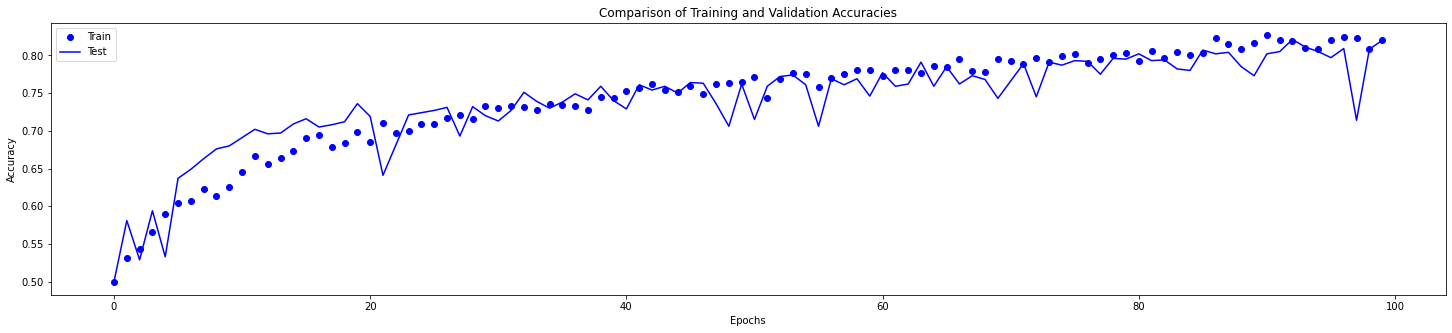

<Figure size 432x288 with 0 Axes>

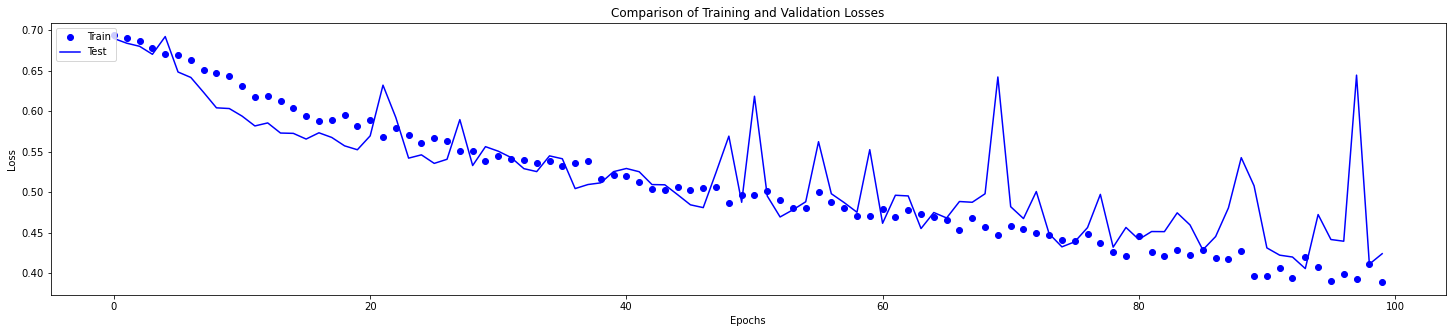

In [24]:
acc2 = history2.history['acc']
val_acc2 = history2.history['val_acc']
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

PlotAccuracyComparison(acc2, val_acc2, lab = 'Model 2')
PlotLossComparison(loss2, val_loss2, lab = 'Model 2')

Thanks to data augmentation and dropout, our model does not overfit. As we can see, the validation curves are rather closely tracking the training curves. We are now able to reach an accuracy of 82-83%, that is ~10% of relative improvement over the non-regularized model.

By leveraging regularization techniques even further and by tuning the network's hyperparameters (such as the number of layers in the network and the number of filters per convolution layer), we may be able to get even better accuracy. The ability to improve this model is limited, simply because we have too little training data to work with. As a next step to improve our accuracy on this problem, we will have to leverage a pre-trained model (transfer learning) and/or use more training examples that are available in this dataset.

In [25]:
import matplotlib.pyplot as plt  # library for plotting math functions: https://matplotlib.org/stable/index.html
    
def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
    
def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (25.0, 5.0) # set default size of plots
    plt.figure(figsize=(25,5))
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

<Figure size 432x288 with 0 Axes>

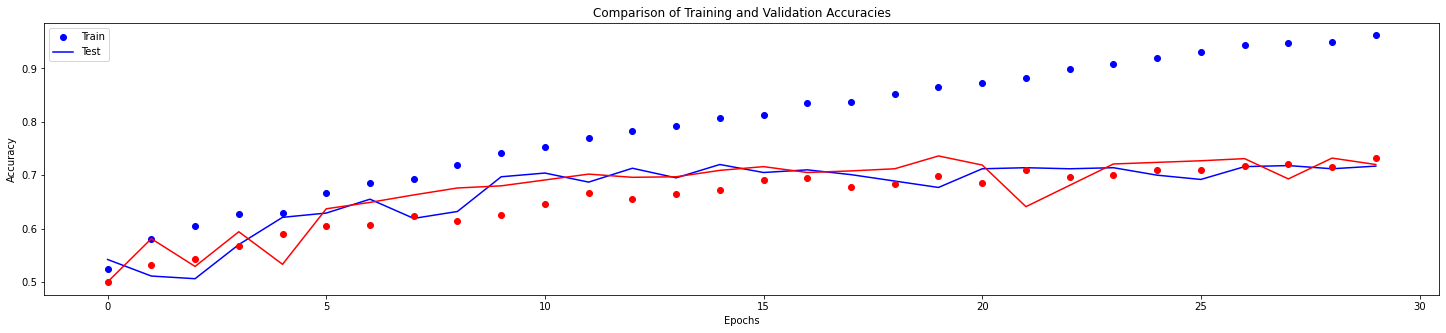

<Figure size 432x288 with 0 Axes>

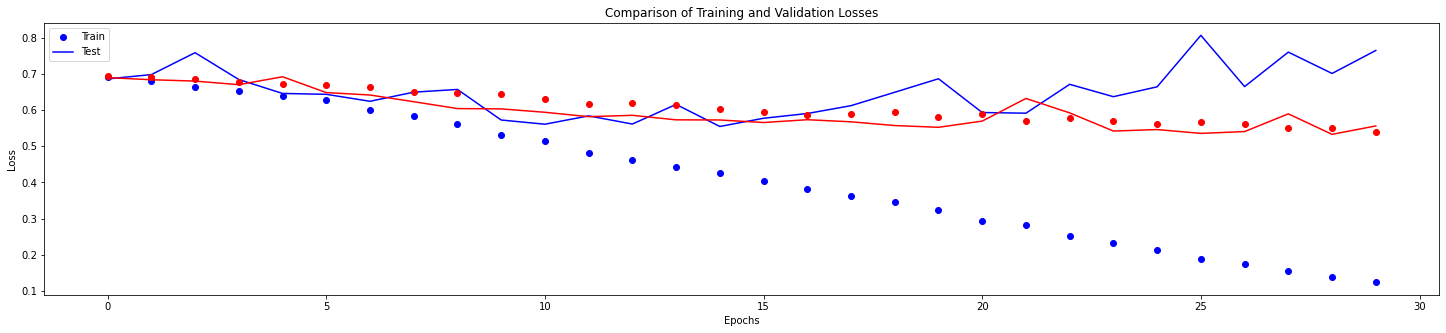

In [26]:
PlotTwoAccuracyComparison(acc1, val_acc1, acc2[:30], val_acc2[:30], lab1 = 'Model 1', lab2 = 'Model 2')
PlotTwoLossComparison(loss1, val_loss1, loss2[:30], val_loss2[:30], lab1 = 'Model 1', lab2 = 'Model 2')

The comparisons of the previous model (in blue) and the augmented model (in red) during the first 30 epochs show that the augmented model does not overfit and provides better generalization.

Now, let's try to do some changes to the model and data augmentation will be used only with training examples.

In [48]:
from keras import layers
from keras import models
from keras import optimizers

model3 = models.Sequential()
model3.add(layers.Conv2D(64, (3, 3), activation='relu', input_shape=(img_rows, img_cols, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(128, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(256, (3, 3), activation='relu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(128, (3, 3), activation='elu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Dropout(0.1))
model3.add(layers.Conv2D(64, (3, 3), activation='elu'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(layers.Flatten())
model3.add(layers.Dropout(0.2))
model3.add(layers.Dense(128, activation='relu'))
model3.add(layers.Dense(16, activation='elu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(loss='binary_crossentropy',
              optimizer=tensorflow.keras.optimizers.RMSprop(learning_rate=1e-4),
              metrics=['acc'])

In [49]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 74, 74, 64)        0         
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 dropout_6 (Dropout)         (None, 36, 36, 128)      

In [50]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=50,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(img_rows, img_cols),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(img_rows, img_cols),
        batch_size=20,
        class_mode='binary')

#history2 = model2.fit_generator(
history3 = model3.fit(
      train_generator,
      steps_per_epoch=100,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/100
100/100 [==============================] - 15s 132ms/step - loss: 0.6983 - acc: 0.5000 - val_loss: 0.6948 - val_acc: 0.5000
Epoch 2/100
100/100 [==============================] - 13s 130ms/step - loss: 0.6951 - acc: 0.5005 - val_loss: 0.6914 - val_acc: 0.5230
Epoch 3/100
100/100 [==============================] - 14s 135ms/step - loss: 0.6919 - acc: 0.5195 - val_loss: 0.6874 - val_acc: 0.5770
Epoch 4/100
100/100 [==============================] - 13s 133ms/step - loss: 0.6872 - acc: 0.5425 - val_loss: 0.6771 - val_acc: 0.5910
Epoch 5/100
100/100 [==============================] - 14s 136ms/step - loss: 0.6800 - acc: 0.5860 - val_loss: 0.6687 - val_acc: 0.5790
Epoch 6/100
100/100 [==============================] - 13s 133ms/step - loss: 0.6747 - acc: 0.5700 - val_loss: 0.6619 - val_acc: 0.5930
Epoch 7/100
100/100 [==============================] - 14s 139ms/step - loss: 0.6653 - acc: 0.6055 -

In [51]:
model3.save(models_dir + 'cats_and_dogs_small_3.h5')

<Figure size 432x288 with 0 Axes>

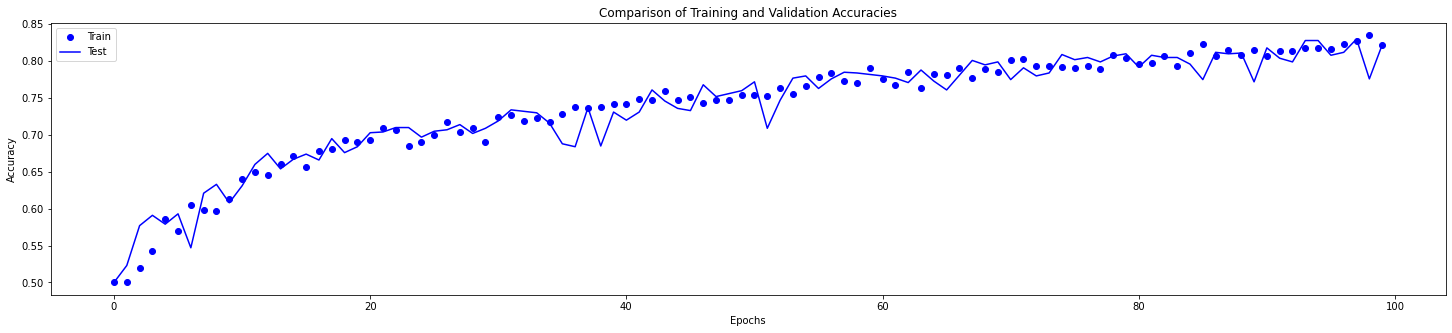

<Figure size 432x288 with 0 Axes>

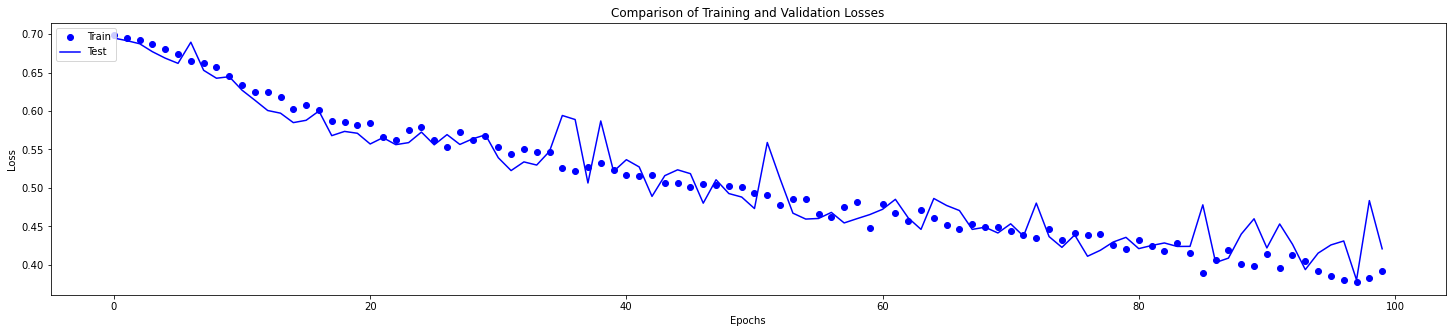

In [52]:
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

PlotAccuracyComparison(acc3, val_acc3, lab = 'Model 3')
PlotLossComparison(loss3, val_loss3, lab = 'Model 3')

<Figure size 432x288 with 0 Axes>

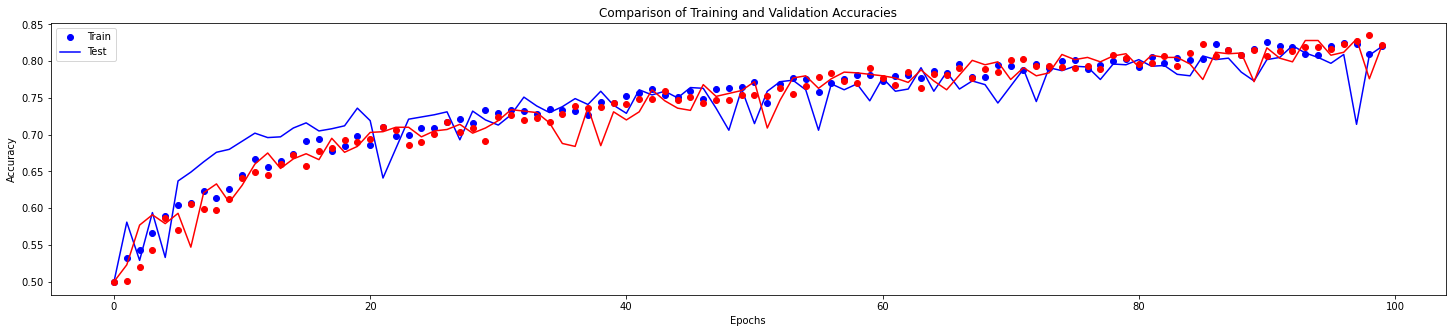

<Figure size 432x288 with 0 Axes>

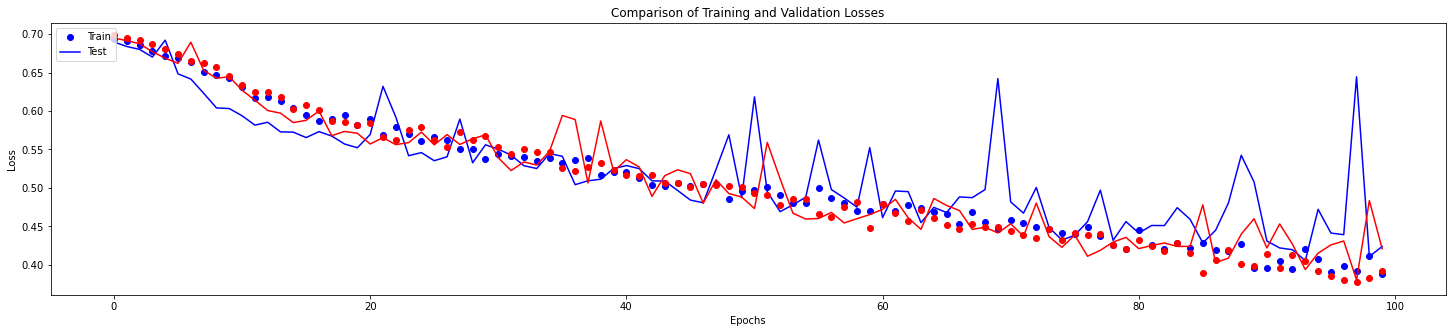

In [53]:
PlotTwoAccuracyComparison(acc2[:100], val_acc2[:100], acc3[:100], val_acc3[:100], lab1 = 'Model 2', lab2 = 'Model 3')
PlotTwoLossComparison(loss2[:100], val_loss2[:100], loss3[:100], val_loss3[:100], lab1 = 'Model 2', lab2 = 'Model 3')

The comparison of the 2nd and 3rd model shows that the third model is more stable and a bit better. Still the number of training examples (limited to 2000) disallows achieving better results.

## ASSIGNMENTS (2 points)

* Modify hyperparameters of the model (the structure, the number of layers in the network and the number of filters per convolution layer, augmentation, regularization, dropout, and the other hyperparameters, add batch normalization, use different activation functions, etc.) and try to achieve higher accuracy.
* Choose more than 2000 training examples from the dataset and check how much it helps to improve the model with a rising number of examples used for training. Increase the number of training examples only, using, e.g., 4000, 8000, up to 23000 examples. If the computational power of your computer is not enough, stop increasing the number of training examples earlier. The validation set and test set use the same as here to have the baseline to compare to the model presented here.
* Compare results achieved for different hyperparameters. Change the hyperparameters one at a time. Draw conclusions about the use of different hyperparameters in your experiments.
* Compare the accuracies and losses of your models using charts (e.g., PlotTwoAccuracyComparison and PlotTwoLossComparison).
* Store the developed model `model2.save(models_dir + 'cats_and_dogs_small_my.h5')` because we will reuse it in the next classes for visualization and inspection of filters!
* Finally, use a different image dataset, e.g., from <a href="www.kaggle.com">Kaggle.com</a> for classification, train it and store it to reuse it in the next classes for visualization and inspection of filters!